# Clustering Workflow with LLM Integration

In [108]:
#pip install pandas openpyxl
import pandas as pd
import json
from datetime import datetime

with open('categories.json', 'r', encoding='utf-8') as file:
        categories = json.load(file)
articles = pd.read_csv("articles.csv",sep="§",engine="python",index_col=0)
for index,element in articles.iterrows():
    category_assigned = []
    source = element['href'].split("/")[2]
    articles.loc[index,'source'] = source
    if "google" in source:
        subject = element['href'].split('/')[5]
        articles.loc[index,'topic'] = subject
    elif 'aws' in source or 'techcommunity' in source:
        subject = element['href'].split('/')[4]
        articles.loc[index,'topic'] = subject
    else:
        subject = 'azure-blog'
        articles.loc[index,'topic'] = subject
    for category in categories:
        if subject in category['topics']:
            category_assigned.append(category['name'])
    
    # Assign the matching categories to the article's category column
    articles.loc[index, 'category'] = str(category_assigned) if category_assigned else 'Other'

dates = articles[pd.to_datetime(articles['date']) >= datetime(2024,10,1)]
print(dates['date'])

                                                  title        date  \
1996  "Backing up Oracle databases to Amazon S3 at s...  26/12/2024   
1997  "Delegated Administrators Guide to Effective C...  24/12/2024   
1998  "AWS Organizations moving an organization memb...  24/12/2024   
1999  "Getting started with Amazon Q Developer opera...  21/12/2024   
2000  "Streamlining Financial Operations: Leveraging...  21/12/2024   
...                                                 ...         ...   
8008  "capa Explorer Web: A Web-Based Tool for Progr...  01/10/2024   
8009  "How virtual red team technology can find high...  01/10/2024   
8010  "Mastering Dataflow: 5 In-Depth Guides to Real...  01/10/2024   
8011  "Migrate your SQL Server databases using Datab...  01/10/2024   
8161  "Mistral AI's Codestral launches as a service,...  23/12/2024   

                                                   href  \
1996  https://aws.amazon.com/blogs/storage/backing-u...   
1997  https://aws.amazon.com/

C:\Users\eloua\AppData\Local\Temp\ipykernel_6436\1629345426.py:29: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dates = articles[pd.to_datetime(articles['date']) >= datetime(2024,10,1)]


## 1. Data Preprocessing and Embedding Generation
Before applying clustering, ensure your data is preprocessed and transformed into embeddings (numerical representations). The quality of these embeddings is crucial for clustering results.

### Steps:
1. **Text Preprocessing**:
   - Clean the text by removing unnecessary characters, stop words, and irrelevant information.
   - Use tokenization or lemmatization for better representation.
   
2. **Feature Extraction**:
   - Use models like BERT, GPT, or other transformer-based models to generate high-quality embeddings.
   - These embeddings capture the semantic information of each text, essential for meaningful clustering.

In [107]:
#pip install nltk spacy scikit-learn
#python -m spacy download en_core_web_sm
import re
import ast
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize Spacy for lemmatization
nlp = spacy.load("en_core_web_sm")

# Download stopwords if not already available
nltk.download('stopwords')
nltk.download('punkt_tab')


# Custom stop words list for IT/technical articles (You can add/remove terms based on your corpus)
custom_stopwords = [
    'using', 'via', 'for', 'in', 'on', 'with', 'at', 'from', 'to', 'by', 'be',
    'and', 'of', 'the', 'a', 'an', 'as', 'is', 'are', 'was', 'were', 'it', 'its', 
    'they', 'them', 'this', 'that', 'which', 'who', 'where', 'how', 'some', 
    'these', 'those', 'at', 'below', 'above', 'model', 'systems', 'data', 
    'information', 'used', 'including', 'use', 'r','many'
    ] 

with open('liste.txt', 'r', encoding='utf-8') as file:
    list_str = file.read().strip()

important_short_words = ast.literal_eval(list_str)

# Preprocessing functions (same as before)
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def tokenize_text(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words and word.lower() not in custom_stopwords]

def lemmatize_with_spacy(tokens):
    doc = nlp(" ".join(tokens))
    processed_tokens = []
    for token in doc:
        token_text_lower = token.text.lower()
        if any(token_text_lower == important_word or token_text_lower == important_word[:-1] for important_word in important_short_words):
            processed_tokens.append(token.text)
        else:
            processed_tokens.append(token.lemma_)
        
    return processed_tokens

def preprocess_text(text,index):
    text = remove_special_characters(text)
    tokens = tokenize_text(text)
    stopwords = remove_stopwords(tokens)
    lemma = lemmatize_with_spacy(stopwords)
    return lemma
print(articles)
articles.to_csv('data.csv',sep='§',index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eloua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eloua\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                                  title        date  \
0     "Deploying Oracle RAC in AWS Outposts via Flas...  30/12/2022   
1     "Watch now: HBO Max automates misconfiguration...  29/12/2022   
2     "Automate tasks in Amazon RDS Custom for Oracl...  27/12/2022   
3     Visualizing Amazon Connect instance metrics wi...  23/12/2022   
4     How patterns can help you plan and implement a...  23/12/2022   
...                                                 ...         ...   
8701  "Introducing the Dataflow ML Starter project: ...  09/01/2024   
8702  "How to deploy data observability with Monte C...  06/01/2024   
8703  "Simplify speech analytics with BigQuery, powe...  05/01/2024   
8704  "BigQuery integrates with Document AI to help ...  05/01/2024   
8705    "FinOps from the Field: Cloud cost forecasting"  03/01/2024   

                                                   href  \
0     https://aws.amazon.com/blogs/architecture/depl...   
1     https://aws.amazon.com/


## 2. Initial Clustering with Traditional Algorithms
Start with a traditional clustering algorithm like K-Means or DBSCAN using the generated embeddings.

### Steps:
1. Use embeddings as input for the clustering algorithm.
2. For K-Means, set a reasonable number of clusters, or let DBSCAN automatically determine the number.

In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [103]:

# Step 1: Vectorization using TF-IDF
single_categories = [category['name'] for category in categories]

liste_categories = []
for cat in single_categories:
    liste_categories.append(articles[articles['category'].apply(lambda x: cat in x)])

vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words='english')  # Adjust thresholds

liste_vectorized = []
for dataframe in liste_categories:
    X = vectorizer.fit_transform(dataframe['processed'].dropna().tolist())
    num_clusters = 4  # You can adjust based on your needs=
    kmeans = KMeans(n_clusters=num_clusters, random_state=48)
    kmeans.fit(X)
    # Evaluate clustering
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    
    # Fixing the issue by converting the last category value to a string before concatenating
    last_category = str(dataframe['category'].iloc[-1])  # Access the last category value
    print(f"Last Category: {last_category}\nSilhouette Score: {score}")
    liste_vectorized.append([last_category,X,labels])


Last Category: ['Infrastructure']
Silhouette Score: 0.017754898190643634
Last Category: ['Storage']
Silhouette Score: 0.0285186874867019
Last Category: ['Application']
Silhouette Score: 0.02104828384385807
Last Category: ['Security']
Silhouette Score: 0.03647946343835827
Last Category: ['Db & Big Data']
Silhouette Score: 0.04247027358655017
Last Category: ['AI & ML']
Silhouette Score: 0.026246417011326646
Last Category: ['Business']
Silhouette Score: 0.02207641064034971
Last Category: ['DevOps']
Silhouette Score: 0.07217982820513283
Last Category: ['Analytics']
Silhouette Score: 0.009560255423068138
Last Category: ['Ecosystem']
Silhouette Score: 0.04000540651594247
Last Category: ['Migration']
Silhouette Score: 0.05753893328255438
Last Category: ['Other']
Silhouette Score: 0.01635153305801569


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

liste_vect = []
for Vect in liste_vectorized:
    # Remove zero rows
    non_zero_rows = Vect[0].getnnz(axis=1) > 0
    liste_vect.append([Vect[0],StandardScaler().fit_transform(Vect[0])])

for v in liste_vect:
    distance_matrix = pdist(v[1], metric='cosine')
    # Hierarchical clustering with cosine similarity
    clustering = AgglomerativeClustering(
        n_clusters=12,  # Adjust based on your expectation*
        linkage='ward'  # Options: 'ward', 'complete', 'average', 'single'
    )
    labels = clustering.fit_predict(v[0].toarray())  # Convert sparse matrix to dense

    # Perform clustering
    linkage_matrix = linkage(distance_matrix, method='average')

    # Visualize dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.show()

"""
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

best_eps = None
best_min_samples = None
best_score = -1

for eps in np.arange(0.1, 1.0, 0.05):
    for min_samples in range(2, 10):
        for met in ['manhattan','euclidean','cosine']:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=met)
            labels = dbscan.fit_predict(X)
            
            if len(set(labels)) > 1:  # At least 2 clusters
                score = silhouette_score(X, labels, metric='cosine')
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

print(f"Best EPS: {best_eps}, Best Min Samples: {best_min_samples}, Best Silhouette Score: {best_score}")
# Add cluster labels to the dataframe
google['cluster'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise points (-1 label)
print(f"Number of clusters: {n_clusters}")

if n_clusters > 1:
    score = silhouette_score(X, labels, metric='cosine')
    print(f"Silhouette Score: {score}")
else:
    print("Not enough clusters to calculate Silhouette Score.")
    
noise_points = np.sum(labels == -1)
print(f"Number of noise points: {noise_points}")"""

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

## 3. Integration of LLMs for Keyphrase Clustering and Disambiguation
After initial clustering, enhance the process using an LLM (e.g., GPT-3 or GPT-4) to generate keyphrases and disambiguate terms.

Steps:
- Keyphrase Generation:
  - Use the LLM to extract meaningful and context-specific keyphrases from each document.
- Disambiguation:
  - Resolve terms or phrases with multiple interpretations using the LLM.

Python Example:
import openai

openai.api_key = 'your-openai-api-key'

def generate_keyphrases(text):
    response = openai.Completion.create(
        engine="text-davinci-003",  # Or GPT-4 if available
        prompt=f"Extract keyphrases from the following text: {text}",
        max_tokens=100
    )
    return response.choices[0].text.strip()

### Example: Generate keyphrases for documents
keyphrases = [generate_keyphrases(doc) for doc in your_documents]

Tip: Fine-tune the prompt to focus on specific aspects like topics, entities, or domains.

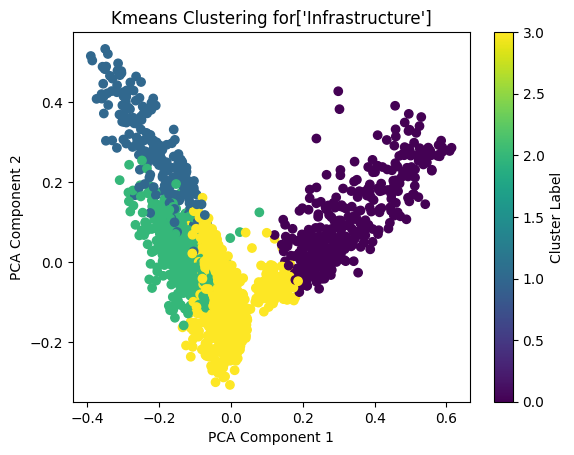

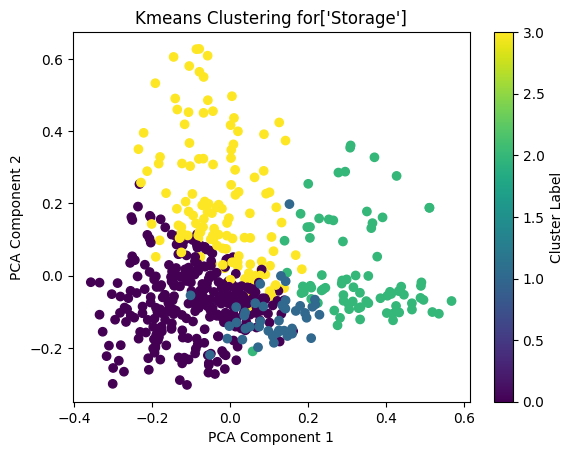

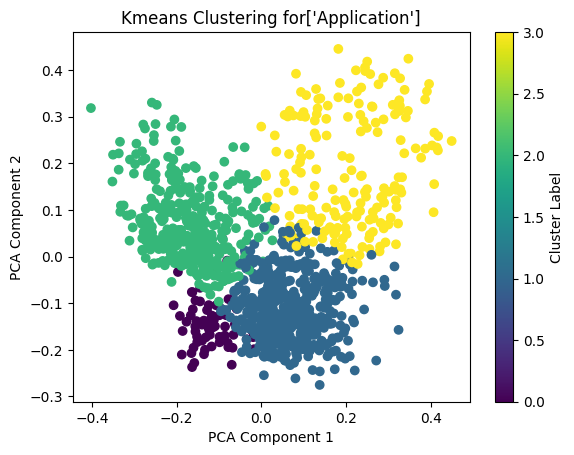

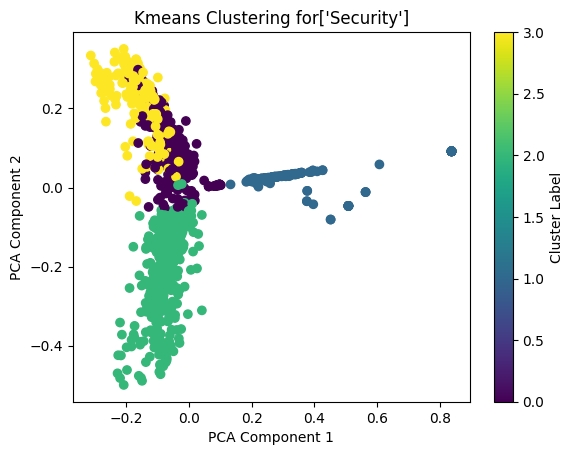

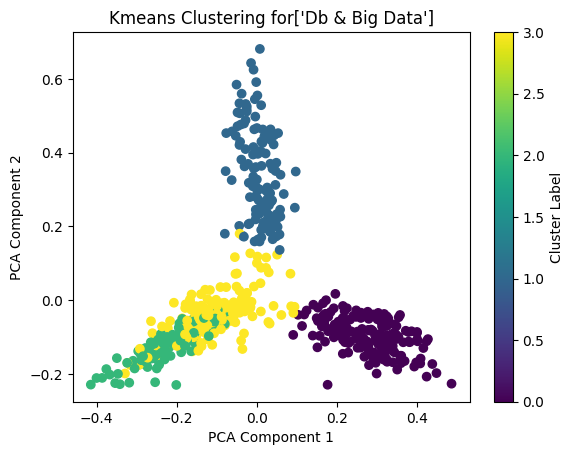

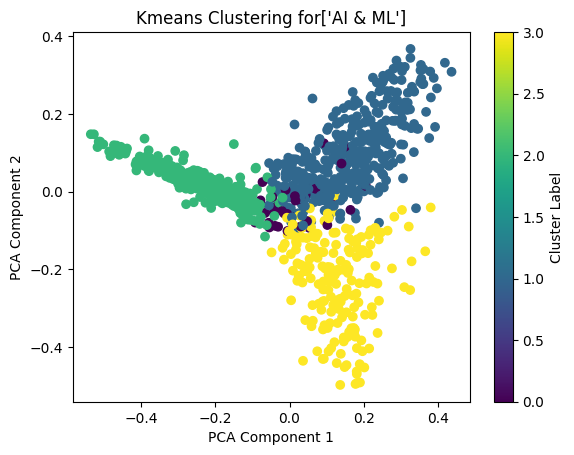

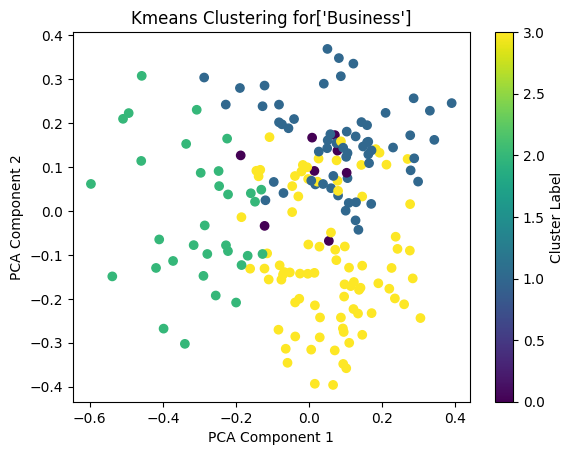

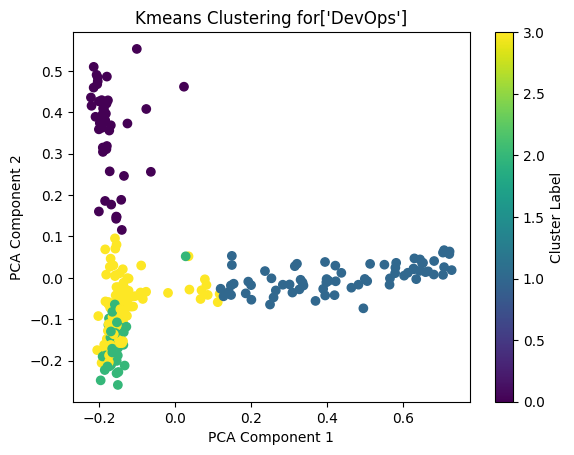

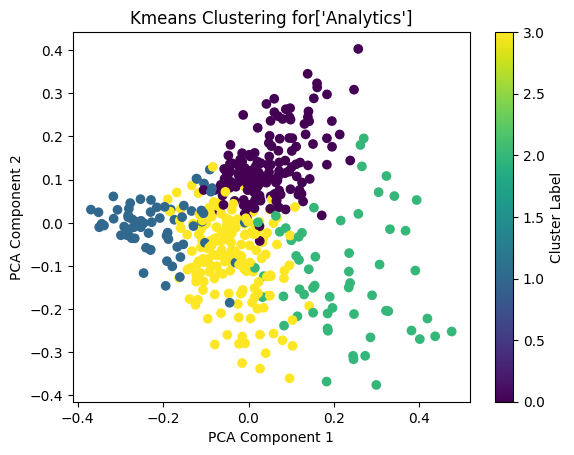

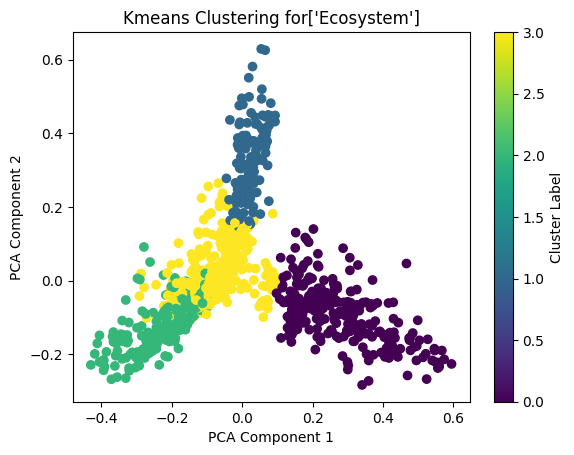

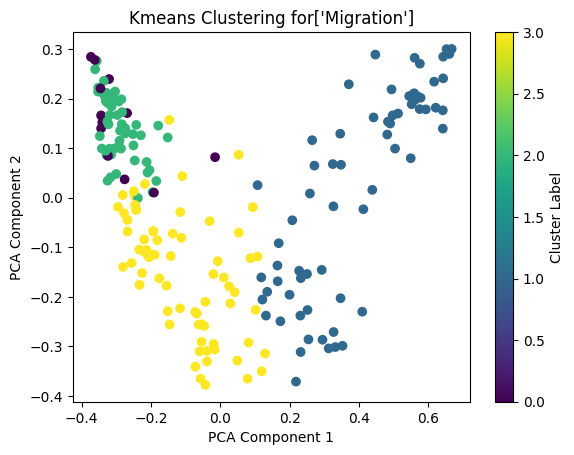

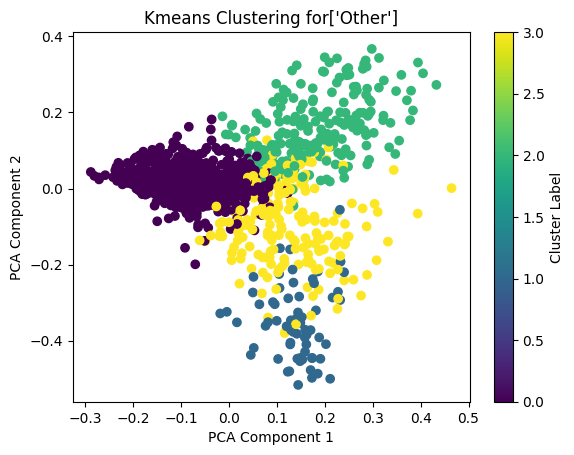

In [104]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions
for v in liste_vectorized:
    pca = PCA(n_components=4)
    X_reduced = pca.fit_transform(v[1].toarray())  # Convert sparse matrix to dense
    # Plot clusters
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=v[2], cmap='viridis')
    plt.title("Kmeans Clustering for"+v[0])
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label='Cluster Label')
    plt.show()

## 4. Clustering Refinement with LLM-Generated Constraints
Use the generated keyphrases as constraints or additional features to refine clustering.

Steps:
- Generate Pairwise Constraints:
  - Use the LLM to determine if two documents belong to the same cluster.
- Reassign Clusters Using Constraints:
  - Apply constraints with clustering algorithms like PCKMeans or constraint-enforced K-Means.

Python Example:
def generate_pairwise_constraints(doc1, doc2):
    prompt = f"Do the following two documents belong to the same category? \nDocument 1: {doc1} \nDocument 2: {doc2}"
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=20
    )
    return response.choices[0].text.strip()

### Generate constraints and refine clustering
constraints = []
for i in range(len(documents)):
    for j in range(i + 1, len(documents)):
        constraints.append(generate_pairwise_constraints(documents[i], documents[j]))

## 5. Fine-Tuning and Iteration
Iteratively improve clustering by:
- Revisiting the embeddings (use advanced models or fine-tune them).
- Optimizing prompts to generate better keyphrases and disambiguation.
- Re-clustering with refined constraints.

## 6. Performance Evaluation
Evaluate clustering results using metrics like:
- Silhouette Score
- Cluster Purity
- Adjusted Rand Index (ARI)

Choose metrics based on the specific task requirements.